# Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load data

In [2]:
DATASET_PATH = "./data"
BERKLEYEARTH_DATASETS = os.path.join(DATASET_PATH, "berkeleyearth")
OWID_DATASETS = os.path.join(DATASET_PATH, "owid")

MONTHLY_ANOMALIES_CSV_PATH = os.path.join(BERKLEYEARTH_DATASETS, "Raw_TAVG_complete.csv")
CO2_EMISSION_CSV_PATH = os.path.join(OWID_DATASETS, "owid-co2-data.csv")

In [3]:
import pandas as pd

temperature_anomalies = pd.read_csv(MONTHLY_ANOMALIES_CSV_PATH)
anual_anomalies = temperature_anomalies[temperature_anomalies['month'] == 6][['year', 'annual_anomaly', 'ten_year_anomaly']]
anual_anomalies

,year,annual_anomaly,ten_year_anomaly
5,1750,0.183,NaN
17,1751,1.075,NaN
29,1752,NaN,NaN
41,1753,0.104,NaN
53,1754,0.785,NaN
...,...,...,...
3209,2017,1.364,NaN
3221,2018,1.208,NaN
3233,2019,1.395,NaN
3245,2020,1.556,NaN


In [4]:
co2_emission = pd.read_csv(CO2_EMISSION_CSV_PATH)
co2_emission_annually = co2_emission[["year", "co2"]].fillna(0).groupby(['year']).sum().reset_index()
co2_emission_annually

,year,co2
0,1750,56.106
1,1751,56.106
2,1752,56.124
3,1753,56.124
4,1754,56.148
...,...,...
267,2017,234500.508
268,2018,238741.382
269,2019,239925.740
270,2020,228766.484


# Calculate cumulative sum for CO2 emission

In [5]:
co2_emission_annually['cum_co2'] = co2_emission_annually['co2'].cumsum()
co2_emission_annually

,year,co2,cum_co2
0,1750,56.106,5.610600e+01
1,1751,56.106,1.122120e+02
2,1752,56.124,1.683360e+02
3,1753,56.124,2.244600e+02
4,1754,56.148,2.806080e+02
...,...,...,...
267,2017,234500.508,1.096420e+07
268,2018,238741.382,1.120294e+07
269,2019,239925.740,1.144287e+07
270,2020,228766.484,1.167164e+07


# Join datasets

In [6]:
co2_emission_annually_since_1860 = co2_emission_annually[co2_emission_annually['year'] >= 1900]
annal_anomalies_since_1860 = anual_anomalies[anual_anomalies['year'] >= 1900]

anomalies_and_co2_anually = annal_anomalies_since_1860.merge(co2_emission_annually_since_1860, how = 'inner', left_on='year', right_on='year')
anomalies_and_co2_anually

,year,annual_anomaly,ten_year_anomaly,co2,cum_co2
0,1900,-0.032,-0.246,14890.575,3.418100e+05
1,1901,-0.023,-0.227,15262.882,3.570728e+05
2,1902,-0.236,-0.244,15559.653,3.726325e+05
3,1903,-0.313,-0.253,16827.715,3.894602e+05
4,1904,-0.474,-0.274,17052.632,4.065128e+05
...,...,...,...,...,...
117,2017,1.364,NaN,234500.508,1.096420e+07
118,2018,1.208,NaN,238741.382,1.120294e+07
119,2019,1.395,NaN,239925.740,1.144287e+07
120,2020,1.556,NaN,228766.484,1.167164e+07


array([[<AxesSubplot: xlabel='annual_anomaly', ylabel='annual_anomaly'>,
        <AxesSubplot: xlabel='co2', ylabel='annual_anomaly'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='annual_anomaly'>,
        <AxesSubplot: xlabel='cum_co2', ylabel='annual_anomaly'>],
       [<AxesSubplot: xlabel='annual_anomaly', ylabel='co2'>,
        <AxesSubplot: xlabel='co2', ylabel='co2'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='co2'>,
        <AxesSubplot: xlabel='cum_co2', ylabel='co2'>],
       [<AxesSubplot: xlabel='annual_anomaly', ylabel='ten_year_anomaly'>,
        <AxesSubplot: xlabel='co2', ylabel='ten_year_anomaly'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='ten_year_anomaly'>,
        <AxesSubplot: xlabel='cum_co2', ylabel='ten_year_anomaly'>],
       [<AxesSubplot: xlabel='annual_anomaly', ylabel='cum_co2'>,
        <AxesSubplot: xlabel='co2', ylabel='cum_co2'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='cum_co2'>,
        <AxesSub

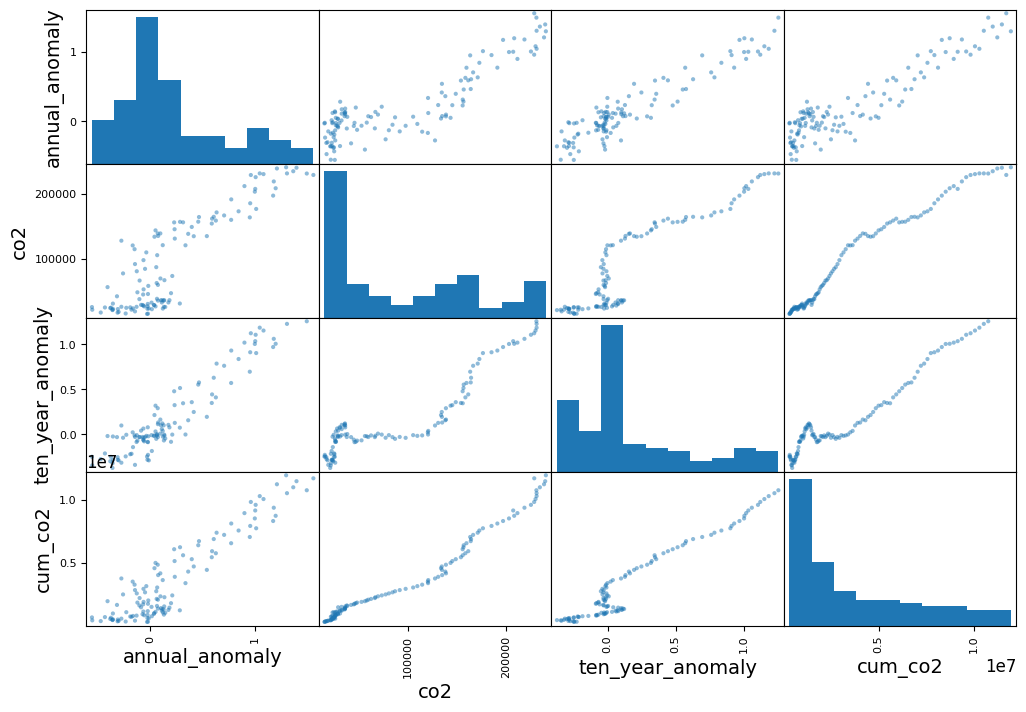

In [7]:
from pandas.plotting import scatter_matrix

attributes = ['annual_anomaly', "co2", 'ten_year_anomaly', 'cum_co2']
scatter_matrix(anomalies_and_co2_anually[attributes], figsize=(12,8))

In [8]:
anomalies_and_co2_anually.corr()

,year,annual_anomaly,ten_year_anomaly,co2,cum_co2
year,1.000000,0.841487,0.881124,0.957844,0.933063
annual_anomaly,0.841487,1.000000,0.938394,0.878617,0.926749
ten_year_anomaly,0.881124,0.938394,1.000000,0.916015,0.967357
co2,0.957844,0.878617,0.916015,1.000000,0.981532
cum_co2,0.933063,0.926749,0.967357,0.981532,1.000000


# Linear Regression

###  Normalize emission of co2 and anomalies

In [59]:
from sklearn import preprocessing as pre

co2 = anomalies_and_co2_anually[["co2"]]
co2_norm = pre.MinMaxScaler().fit_transform(co2)

cum_co2 = anomalies_and_co2_anually[["cum_co2"]]
cum_co2_norm = pre.MinMaxScaler().fit_transform(cum_co2)

annual_anomaly = anomalies_and_co2_anually[["annual_anomaly"]]
annual_anomaly_norm = pre.MinMaxScaler().fit_transform(annual_anomaly)

ten_year_anomaly = anomalies_and_co2_anually[["ten_year_anomaly"]]
ten_year_anomaly_norm = pre.MinMaxScaler().fit_transform(ten_year_anomaly)


In [10]:
to_normalized_value = anomalies_and_co2_anually[["co2", "cum_co2", "annual_anomaly", "ten_year_anomaly"]].values

min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(to_normalized_value)
df_scaled = pd.DataFrame(x_scaled, columns = ["co2", "cum_co2", "annual_anomaly", "ten_year_anomaly"], index = anomalies_and_co2_anually.index)

df_scaled['year'] = anomalies_and_co2_anually[["year"]]
anomalies_and_co2_anually_scaled = df_scaled

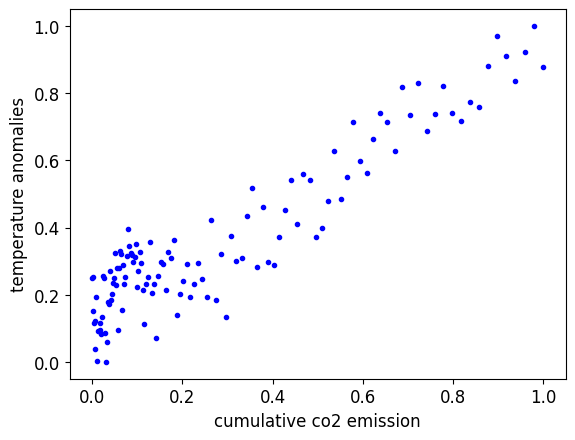

In [34]:
anomalies_and_co2_anually = anomalies_and_co2_anually_scaled.dropna()
Y = anomalies_and_co2_anually_scaled[['annual_anomaly']]
X = anomalies_and_co2_anually_scaled[['cum_co2']]

# plot points instead of lines
plt.plot(X, Y, ".b")
plt.xlabel("cumulative co2 emission", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
plt.show()

### Normal eqation method
We'll use *normal equation* for calcuation linear regression parameters

$$
\Theta = (X^TX)^{-1}X^Ty
$$

In [42]:
import numpy as np

x_len, _ = X.shape
X_b = np.c_[np.ones((x_len, 1)), X]

# normal equation for linear regression 
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)

In [43]:
theta

array([[0.14551849],
       [0.7704561 ]])

In [50]:
# we want to calculate y value for points x = 0 and x = 1
X_new = np.array([[0], [1]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
Y_predict = X_new_b.dot(theta)
Y_predict


array([[0.14551849],
       [0.9159746 ]])

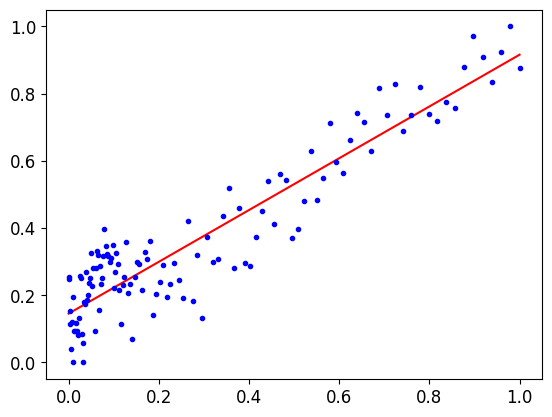

In [51]:
plt.plot(X_new, Y_predict, "r-")
plt.plot(X, Y, "b.")
plt.show()

### Latest square method


In [56]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, Y)
lin_reg.intercept_, lin_reg.coef_


(array([0.14551849]), array([[0.7704561]]))

In [57]:
# prediction for x=0 and x=1
lin_reg.predict(X_new)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[0.14551849],
       [0.9159746 ]])

In [58]:
# Coefficient of determination of the prediction.
lin_reg.score(X,Y)

0.8588639205536893